<a href="https://colab.research.google.com/github/kaushiki9/cfa/blob/main/cfa1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


In [38]:
pip install ta


In [39]:
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator

In [40]:
ticker = 'TCS.NS'
data = yf.download(ticker, start='2020-01-01', end='2025-01-01')
data.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed


In [41]:
# === Indicators ===
data['SMA200'] = data['Close'].rolling(window=200).mean()


In [42]:
from ta.volatility import BollingerBands

# Extract the Close price as a 1D Series (not a DataFrame)
close_series = data[('Close', 'TCS.NS')]

# Calculate Bollinger Bands
bb = BollingerBands(close=close_series, window=20, window_dev=2)

# Assign results back to the original DataFrame (as flat-level columns)
data[('bb_upper', '')] = bb.bollinger_hband()
data[('bb_lower', '')] = bb.bollinger_lband()
data[('bb_mavg', '')] = bb.bollinger_mavg()


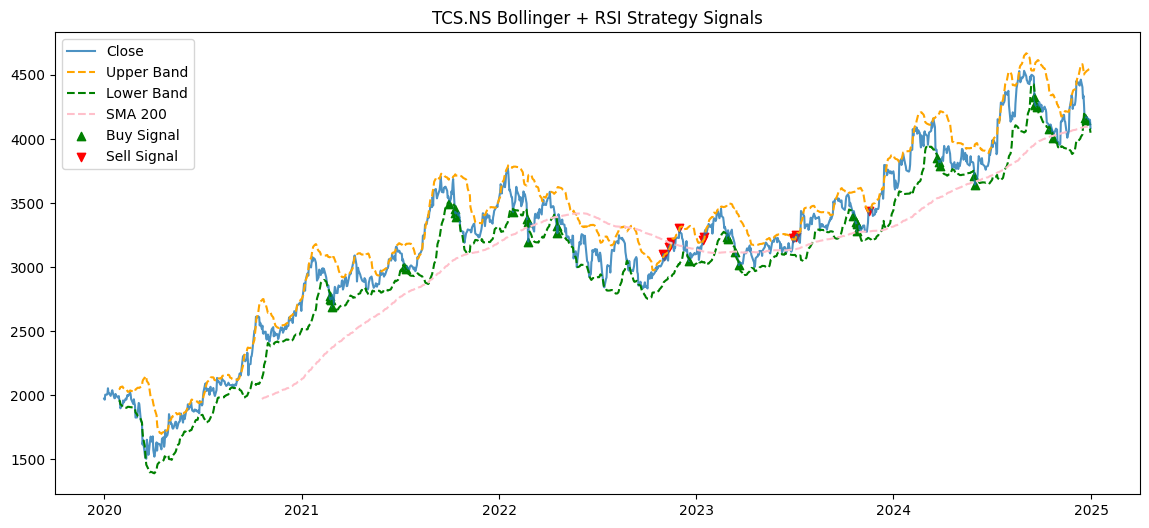

In [43]:
import pandas as pd
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator

close = data[('Close', 'TCS.NS')]
close.name = 'Close'

bb = BollingerBands(close=close, window=20, window_dev=2)
data[('bb_upper', '')] = bb.bollinger_hband()
data[('bb_lower', '')] = bb.bollinger_lband()


rsi = RSIIndicator(close=close, window=14)
data[('RSI', '')] = rsi.rsi()


data[('Prev_Close', '')] = close.shift(1)
data[('Prev_bb_lower', '')] = data[('bb_lower', '')].shift(1)
data[('Prev_bb_upper', '')] = data[('bb_upper', '')].shift(1)


sma200 = data[('SMA200', '')]


buy = (
    (data[('Close', 'TCS.NS')] <= data[('bb_lower', '')]) &
    (data[('RSI', '')] < 50) &                                  # Some weakness
    (data[('Close', 'TCS.NS')] > data[('SMA200', '')] * 0.95)
)

# New Sell Condition (less strict)
sell = (
    (data[('Close', 'TCS.NS')] >= data[('bb_upper', '')]) &
    (data[('RSI', '')] > 50) &                                  # Some strength
    (data[('Close', 'TCS.NS')] < data[('SMA200', '')] * 1.05)   # At or near SMA200
)


# signals
data[('Buy', '')] = buy
data[('Sell', '')] = sell


data['Position'] = 0
position = 0
for i in range(len(data)):
    if data['Buy'].iloc[i]:
        position = 1
    elif data['Sell'].iloc[i]:
        position = 0
    data.at[data.index[i], 'Position'] = position



data['Returns'] = data['Close'].pct_change()
data['Strategy'] = data['Position'].shift(1) * data['Returns']
data[['Cumulative BuyHold', 'Cumulative Strategy']] = (1 + data[['Returns', 'Strategy']]).cumprod()


plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Close', alpha=0.8)
plt.plot(data['bb_upper'], label='Upper Band', linestyle='--', color='orange')
plt.plot(data['bb_lower'], label='Lower Band', linestyle='--', color='green')
plt.plot(data['SMA200'], label='SMA 200', linestyle='--', color='pink')
plt.scatter(data.index[data['Buy']], data['Close'][data['Buy']], marker='^', color='green', label='Buy Signal')
plt.scatter(data.index[data['Sell']], data['Close'][data['Sell']], marker='v', color='red', label='Sell Signal')

plt.legend()
plt.title(f"{ticker} Bollinger + RSI Strategy Signals")
plt.show()

In [44]:
# Risk-free rate: 6% annual in India → daily
risk_free_rate_daily = 0.06 / 252

# Drop NaNs
strategy_returns = data['Strategy'].dropna()
n_days = strategy_returns.shape[0]

if n_days == 0:
    print(" No strategy returns to evaluate. Check your buy/sell signals or backtest logic.")
else:
    cumulative_return = (1 + strategy_returns).prod() - 1
    annualized_return = (1 + cumulative_return) ** (252 / n_days) - 1
    sharpe_ratio = (strategy_returns.mean() - risk_free_rate_daily) / strategy_returns.std() * np.sqrt(252)

    downside_returns = strategy_returns[strategy_returns < 0]
    sortino_ratio = (strategy_returns.mean() - risk_free_rate_daily) / downside_returns.std() * np.sqrt(252)

    cumulative = (1 + strategy_returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_drawdown = drawdown.min()

    trades = strategy_returns[strategy_returns != 0]
    profits = trades[trades > 0]
    losses = trades[trades < 0]

    win_rate = len(profits) / len(trades) if len(trades) > 0 else np.nan
    profit_factor = profits.sum() / -losses.sum() if losses.sum() != 0 else np.nan
    avg_profit = profits.mean() if not profits.empty else 0
    avg_loss = losses.mean() if not losses.empty else 0
    max_profit = trades.max() if not trades.empty else 0
    max_loss = trades.min() if not trades.empty else 0

    metrics = {
        'Cumulative Return': cumulative_return,
        'Annualized Return': annualized_return,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Maximum Drawdown': max_drawdown,
        'Win Rate': win_rate,
        'Profit Factor': profit_factor,
        'Avg Profit': avg_profit,
        'Avg Loss': avg_loss,
        'Max Profit': max_profit,
        'Max Loss': max_loss,
    }

    print(" Strategy Performance Metrics:")
    for key, val in metrics.items():
        print(f"{key}: {val:.4f}")




 Strategy Performance Metrics:
Cumulative Return: 0.2721
Annualized Return: 0.0503
Sharpe Ratio: 0.0127
Sortino Ratio: 0.0139
Maximum Drawdown: -0.2498
Win Rate: 0.5138
Profit Factor: 1.0906
Avg Profit: 0.0098
Avg Loss: -0.0095
Max Profit: 0.0663
Max Loss: -0.0635


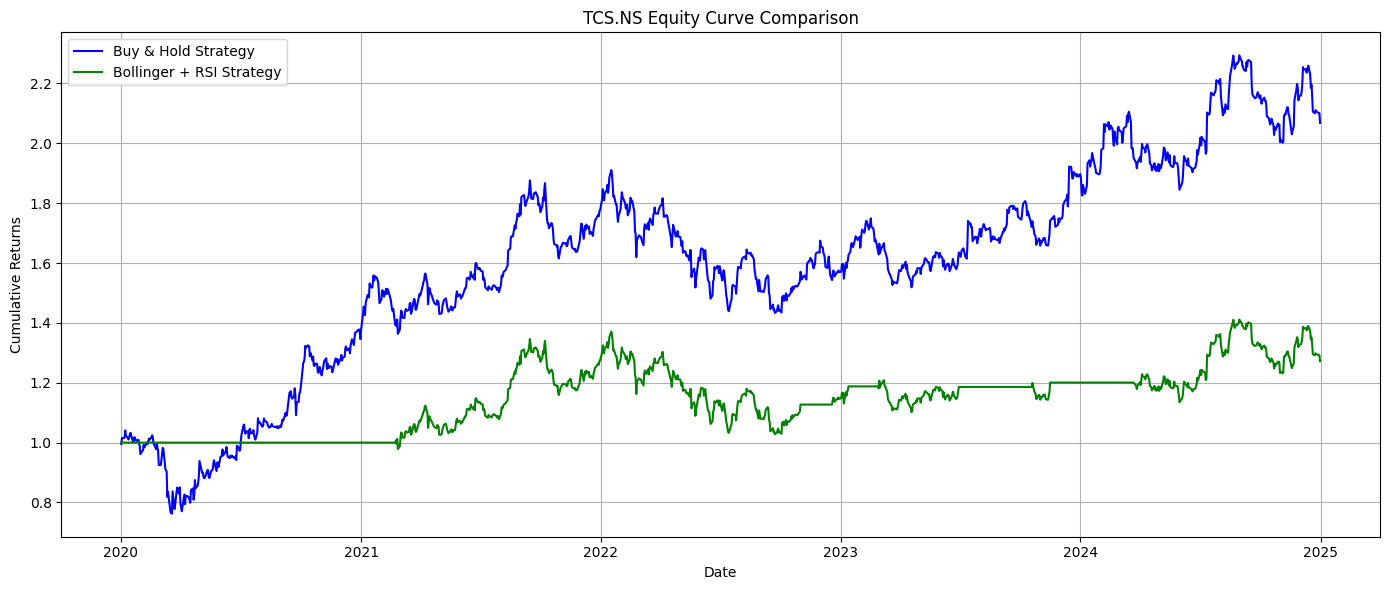

In [45]:

plt.figure(figsize=(14, 6))
plt.plot(data['Cumulative BuyHold'], label='Buy & Hold Strategy', color='blue')
plt.plot(data['Cumulative Strategy'], label='Bollinger + RSI Strategy', color='green')

plt.title(f"{ticker} Equity Curve Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


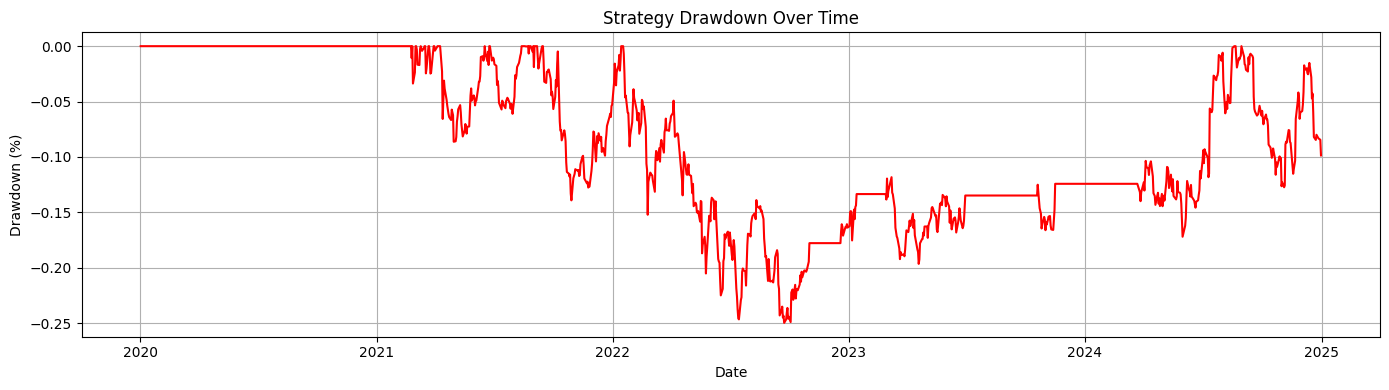

In [46]:
# Calculate drawdowns
cumulative = data['Cumulative Strategy']
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max

# Plot
plt.figure(figsize=(14, 4))
plt.plot(drawdown, color='red')
plt.title('Strategy Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


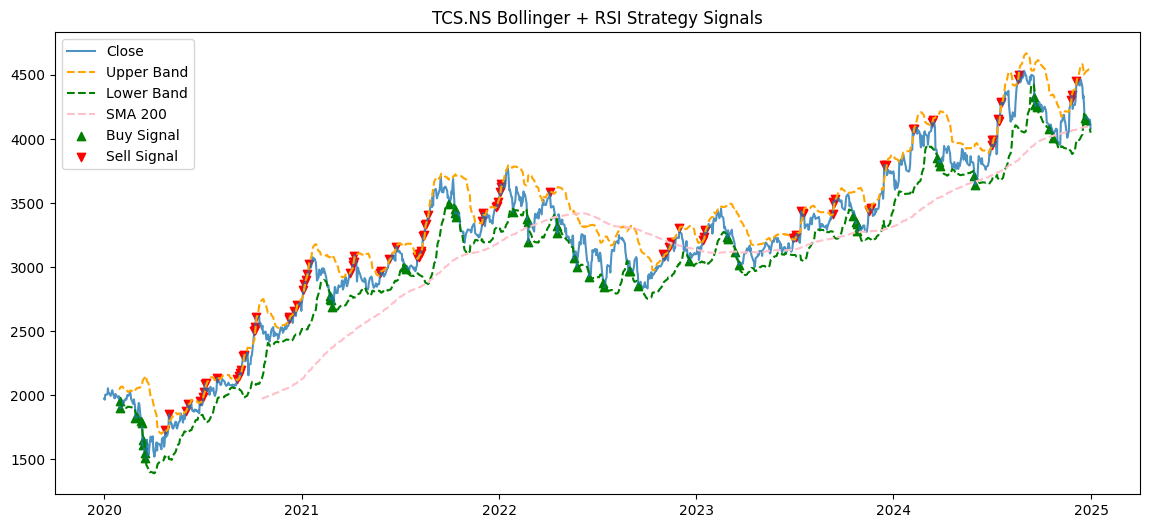

In [47]:
buy = (
    (data[('Close', 'TCS.NS')] < data[('bb_lower', '')]) &
    (data[('RSI', '')] < 50)
)
sell = (
    (data[('Close', 'TCS.NS')] > data[('bb_upper', '')]) &
    (data[('RSI', '')] > 50)
)
# STEP 7: Assign signals
data[('Buy', '')] = buy
data[('Sell', '')] = sell

# === Position Tracking ===
data['Position'] = 0
position = 0
for i in range(len(data)):
    if data['Buy'].iloc[i]:
        position = 1
    elif data['Sell'].iloc[i]:
        position = 0
    data.at[data.index[i], 'Position'] = position



data['Returns'] = data[('Close', 'TCS.NS')].pct_change()
data['Strategy'] = data['Position'].shift(1) * data['Returns']
data['Cumulative_BuyHold'] = (1 + data['Returns']).cumprod()
data['Cumulative_Strategy'] = (1 + data['Strategy']).cumprod()


plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Close', alpha=0.8)
plt.plot(data['bb_upper'], label='Upper Band', linestyle='--', color='orange')
plt.plot(data['bb_lower'], label='Lower Band', linestyle='--', color='green')
plt.plot(data['SMA200'], label='SMA 200',  linestyle='--', color='pink')
plt.scatter(data.index[data['Buy']], data['Close'][data['Buy']], marker='^', color='green', label='Buy Signal')
plt.scatter(data.index[data['Sell']], data['Close'][data['Sell']], marker='v', color='red', label='Sell Signal')

plt.legend()
plt.title(f"{ticker} Bollinger + RSI Strategy Signals")
plt.show()

In [48]:
print(data[['Position', 'Returns', 'Strategy']].tail(10))


Price      Position   Returns  Strategy
Ticker                                 
Date                                   
2024-12-17        0 -0.019637 -0.000000
2024-12-18        0  0.004470  0.000000
2024-12-19        0 -0.017468 -0.000000
2024-12-20        1 -0.023783 -0.000000
2024-12-23        1 -0.002877 -0.002877
2024-12-24        1  0.005098  0.005098
2024-12-26        1 -0.002488 -0.002488
2024-12-27        1 -0.001019 -0.001019
2024-12-30        1 -0.001453 -0.001453
2024-12-31        1 -0.015389 -0.015389


In [49]:
import numpy as np

# Risk-free rate: 6% annual in India → daily
risk_free_rate_daily = 0.06 / 252

# Drop NaNs
strategy_returns = data['Strategy'].dropna()
n_days = strategy_returns.shape[0]

if n_days == 0:
    print("⚠️ No strategy returns to evaluate. Check your buy/sell signals or backtest logic.")
else:
    cumulative_return = (1 + strategy_returns).prod() - 1
    annualized_return = (1 + cumulative_return) ** (252 / n_days) - 1
    sharpe_ratio = (strategy_returns.mean() - risk_free_rate_daily) / strategy_returns.std() * np.sqrt(252)

    downside_returns = strategy_returns[strategy_returns < 0]
    sortino_ratio = (strategy_returns.mean() - risk_free_rate_daily) / downside_returns.std() * np.sqrt(252)

    cumulative = (1 + strategy_returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_drawdown = drawdown.min()

    trades = strategy_returns[strategy_returns != 0]
    profits = trades[trades > 0]
    losses = trades[trades < 0]

    win_rate = len(profits) / len(trades) if len(trades) > 0 else np.nan
    profit_factor = profits.sum() / -losses.sum() if losses.sum() != 0 else np.nan
    avg_profit = profits.mean() if not profits.empty else 0
    avg_loss = losses.mean() if not losses.empty else 0
    max_profit = trades.max() if not trades.empty else 0
    max_loss = trades.min() if not trades.empty else 0

    metrics = {
        'Cumulative Return': cumulative_return,
        'Annualized Return': annualized_return,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Maximum Drawdown': max_drawdown,
        'Win Rate': win_rate,
        'Profit Factor': profit_factor,
        'Avg Profit': avg_profit,
        'Avg Loss': avg_loss,
        'Max Profit': max_profit,
        'Max Loss': max_loss,
    }

    print("📊 Strategy Performance Metrics:")
    for key, val in metrics.items():
        print(f"{key}: {val:.4f}")




📊 Strategy Performance Metrics:
Cumulative Return: -0.0228
Annualized Return: -0.0047
Sharpe Ratio: -0.2780
Sortino Ratio: -0.2369
Maximum Drawdown: -0.2561
Win Rate: 0.4964
Profit Factor: 1.0175
Avg Profit: 0.0115
Avg Loss: -0.0111
Max Profit: 0.0985
Max Loss: -0.0941


[*********************100%***********************]  1 of 1 completed

 Information Ratio: -0.8153
 Beta: 0.5241
 Alpha: -0.0004


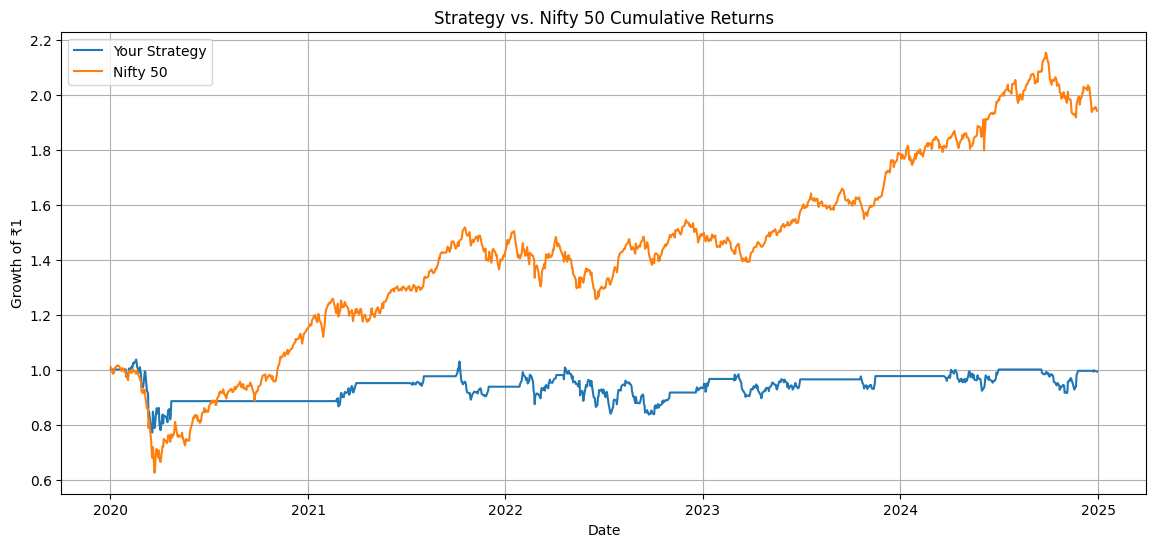

In [50]:
import yfinance as yf
import pandas as pd

# Download Nifty 50 data
nifty = yf.download("^NSEI", start=data.index.min(), end=data.index.max())
nifty['Nifty_Returns'] = nifty['Close'].pct_change()

# Align with strategy
strategy_returns = data['Strategy'].dropna()
combined = pd.concat([strategy_returns, nifty['Nifty_Returns']], axis=1, join='inner')
combined.columns = ['Strategy', 'Benchmark']
strategy_returns = combined['Strategy']
benchmark_returns = combined['Benchmark']
# Now compute metrics as discussed
import numpy as np

# Information Ratio
excess_returns = strategy_returns - benchmark_returns
information_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)

# Beta and Alpha
cov_matrix = np.cov(strategy_returns, benchmark_returns)
beta = cov_matrix[0, 1] / cov_matrix[1, 1]

rf_daily = 0.06 / 252  # 6% annual risk-free rate
alpha = (strategy_returns.mean() - rf_daily) - beta * (benchmark_returns.mean() - rf_daily)

# Print
print(f" Information Ratio: {information_ratio:.4f}")
print(f" Beta: {beta:.4f}")
print(f" Alpha: {alpha:.4f}")

cumulative_returns = (1 + combined).cumprod()

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(cumulative_returns['Strategy'], label='Your Strategy')
plt.plot(cumulative_returns['Benchmark'], label='Nifty 50')
plt.title("Strategy vs. Nifty 50 Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Growth of ₹1")
plt.legend()
plt.grid(True)
plt.show()



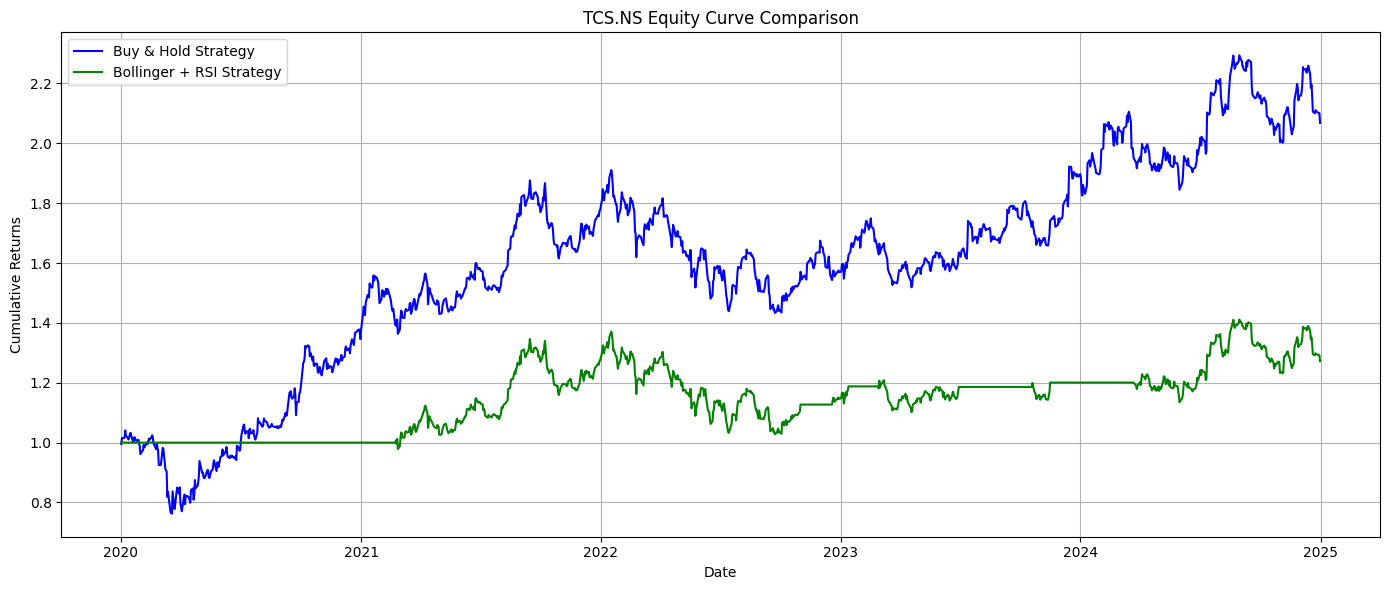

In [51]:

plt.figure(figsize=(14, 6))
plt.plot(data['Cumulative BuyHold'], label='Buy & Hold Strategy', color='blue')
plt.plot(data['Cumulative Strategy'], label='Bollinger + RSI Strategy', color='green')

plt.title(f"{ticker} Equity Curve Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


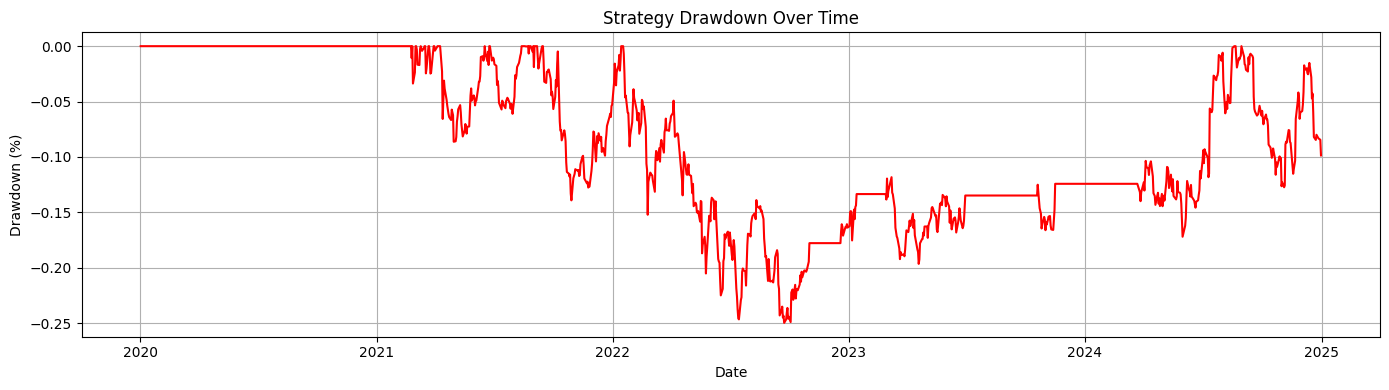

In [52]:
# Calculate drawdowns
cumulative = data['Cumulative Strategy']
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max

# Plot
plt.figure(figsize=(14, 4))
plt.plot(drawdown, color='red')
plt.title('Strategy Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.grid(True)
plt.tight_layout()
plt.show()
